In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from pprint import pprint

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import ModelEvaluation as me
from datetime import datetime,timedelta

import os
from db_utils.pg_connect import pg_connect

from IPython.display import display, HTML, Image
from subprocess import call
import gc
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [2]:
config_file = os.path.join(os.environ['HOME'], '.databases.conf')
dbu = pg_connect("whatif", config_file)

In [3]:
# TEST THAT EVERYTHING IS WORKING
df = dbu.get_df_from_query("select * from pg_tables limit 5")
df.head(2)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,pg_catalog,systable_topology,rdsdb,None,False,False,False
1,pg_catalog,systable_schema,rdsdb,None,False,False,False


In [4]:
# SET END DATE
date_data_accessed = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
# TIME WINDOW SET IN DAYS, TELLS US HOW MANY DAYS TO GO BACK
lengthtimewindow = -30

# Attrition Data

In [5]:
sql = """
WITH offers_seen AS
(
  SELECT imp.user_session_id,
         imp.num_offers_seen
  FROM tracking.user_impression imp
    INNER JOIN tracking.user_impression_linkout_revenue r ON imp.id = r.user_impression_id
  WHERE imp.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
),
session_max_offers_seen AS
(
  SELECT user_session_id AS s_id,
         MAX(num_offers_seen) AS offers
  FROM tracking.user_impression
  WHERE created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
  GROUP BY 1
),
linkouts_url AS
(
  SELECT o.name,
         i.offer_id,
         MAX(CASE WHEN CASE WHEN an_l.url IS NULL THEN o.offer_url ELSE an_l.url END IS NULL THEN o.linkout_url ELSE an_l.url END) AS url
  FROM tracking.user_impression i
    INNER JOIN offers o ON o.id = i.offer_id
    LEFT JOIN tracking.user_offer_question_answer qa ON i.id = qa.user_impression_id
    LEFT JOIN offer_question_answer an ON qa.offer_question_answer_id = an.id
    LEFT JOIN offer_question_answer_linkout an_l ON an_l.offer_question_answer_id = an.id
  WHERE i.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
  GROUP BY 1,
           2
),
linkouts_identify AS
(
  SELECT offer_id AS id,
         CASE
           WHEN url IS NOT NULL THEN 1
           ELSE 0
         END AS is_linkout
  FROM linkouts_url
),
initial_dataset AS
(
  SELECT t1.id AS imp_id,
         t1.user_session_id,
         t1.offer_id,
         t3.name AS offer_name,
         t2.name AS offer_type,
         t1.sequence_id,
         t4.name AS sequence_name,
         t1.order_by,
         CASE
           WHEN t6.offers > t1.num_offers_seen THEN t1.id
           WHEN t7.num_offers_seen IS NULL THEN t1.id
           ELSE NULL
         END AS true_imp_id,
         RANK() OVER (PARTITION BY t1.user_session_id,t1.sequence_id ORDER BY t1.created_at ASC) AS display_order,
         DENSE_RANK() OVER (PARTITION BY t1.sequence_id ORDER BY t1.order_by::INT ASC) AS ranked_order_by,
         t5.is_linkout,
         continued,
         answer,
         tcpa_opt_in_time,
         clicked,
         calculated_revenue
  FROM tracking.user_impression AS t1
    LEFT JOIN public.offer_types AS t2 ON t1.offer_type_id = t2.id
    LEFT JOIN public.offers AS t3 ON t1.offer_id = t3.id
    LEFT JOIN public.sequences AS t4 ON t1.sequence_id = t4.id
    LEFT JOIN linkouts_identify AS t5 ON t1.offer_id = t5.id
    INNER JOIN session_max_offers_seen AS t6 ON t1.user_session_id = t6.s_id
    LEFT JOIN offers_seen AS t7
           ON t1.user_session_id = t7.user_session_id
          AND t1.num_offers_seen - 1 = t7.num_offers_seen
    LEFT JOIN tracking.user_offer_question_answer t8 ON t1.id = t8.user_impression_id
    LEFT JOIN offer_question_answer t9 ON t8.offer_question_answer_id = t9.id
    INNER JOIN tracking.user_session t10 ON t1.user_session_id = t10.id
  WHERE t1.created_at::DATE BETWEEN dateadd(days,{0},'{1}') AND '{1}'
),
final_set AS
(
  SELECT sequence_id,
         offer_id,
         offer_name,
         offer_type,
         --display_order,
         order_by,
         ranked_order_by,
         is_linkout,
         AVG(display_order) AS avg_display_order,
         COUNT(DISTINCT true_imp_id) AS true_impressions,
         COUNT(DISTINCT user_session_id) AS impressions,
         CASE
           WHEN offer_type = 'Question' THEN COUNT(DISTINCT
             CASE
               WHEN answer IN ('Yes','Show Me Now!','Get my samples now!') THEN imp_id
               ELSE NULL
             END )
           ELSE COUNT(DISTINCT
             CASE
               WHEN clicked = 'true' THEN user_session_id
               ELSE NULL
             END )
         END 
         +
         (CASE
            WHEN offer_type NOT IN ('Question','Banner') AND offer_name LIKE '%onfirm%' 
            THEN COUNT(DISTINCT CASE WHEN tcpa_opt_in_time IS NOT NULL THEN user_session_id ELSE NULL END)
            ELSE 0
          END) AS clicks,
         clicks::FLOAT/(CASE WHEN true_impressions = 0 THEN 1 ELSE true_impressions END) as true_ctr,
          1000 *(COALESCE(SUM(calculated_revenue),0)) /(COUNT(DISTINCT imp_id))::FLOAT AS cpm,
          1 -((COUNT(DISTINCT CASE WHEN continued = 'true' THEN user_session_id ELSE NULL END))/(COUNT(DISTINCT user_session_id))::FLOAT) AS attrition
  FROM initial_dataset
  GROUP BY 1,2,3,4,5,6,7
),
averages as (
  SELECT offer_id,
         offer_name,
         offer_type,
         order_by,
         ranked_order_by,
         is_linkout,
         AVG(clicks) as avg_clicks,
         AVG(true_ctr) as avg_true_ctr,
         AVG(cpm) as avg_cpm,
         AVG(attrition) as avg_attrition
  FROM final_set
  GROUP BY 1,2,3,4,5,6
)
SELECT *
FROM final_set
JOIN averages 
USING (offer_id,offer_name,offer_type,order_by,ranked_order_by,is_linkout);
""".format(lengthtimewindow,date_data_accessed)
attrition_data = dbu.get_df_from_query(sql)
attrition_data.shape

(14235, 18)

# Classes

In [17]:
class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

class CategoricalColumnSelector(TransformerMixin):
    def __init__(self,feats):
        self.feats = feats

    def transform(self, X, y=None):
        regstr = ''
        length = len(self.feats)
        for i,feat in enumerate(self.feats):
            regstr = regstr+'^'+feat+'_+'

            if i < length-1:
                regstr = regstr+'|'
        return X.filter(regex=regstr)

    def fit(self, X, y=None):
        return self

class ToSparse(TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, y=None):
        return sparse.csr_matrix(X)

    def fit(self, X, y=None):
        return self


In [18]:
def build_dummies(dataframe,feats):
    df = pd.DataFrame()
    for feat in feats:
        df = pd.concat([df,pd.get_dummies(dataframe[feat],prefix=feat)],axis=1,sort=False)
    df = pd.concat([dataframe,df],axis=1,sort=False)
    df.drop(feats,axis=1,inplace=True)
    return df

def get_cat_features(DF):
    offer_name = DF.filter(regex='^offer_name_+').columns.tolist()
    offer_type = DF.filter(regex='^offer_type_+').columns.tolist()
    cat_feats = offer_name + offer_type
    return cat_feats

def best_params(grid):
    estimator = grid.best_estimator_
    svd = grid.best_estimator_.steps[1][1]
    classifier = grid.best_estimator_.steps[2][1]
    params = grid.best_params_
    score = grid.best_score_
    return estimator,svd,classifier,params,score

In [19]:
attrition_data.head()

,offer_id,offer_name,offer_type,order_by,ranked_order_by,is_linkout,sequence_id,avg_display_order,true_impressions,impressions,clicks,true_ctr,cpm,attrition,avg_clicks,avg_true_ctr,avg_cpm,avg_attrition
0,387,Summer Samples - DYN,Banner,27,25,0,4052,8,3054,3108,1954,0.639817,285.971686,0.140605,1954,0.639817,285.971686,0.140605
1,2380,Summer Samples Prequal PC,Question,60,47,0,4067,14,2041,2176,567,0.277805,4.103860,0.102941,709,0.275222,2.051930,0.094543
2,1803,Final Expense - Crisp Required,Question,34,29,0,3994,10,1955,1959,141,0.072123,35.936702,0.022460,91,0.068025,33.408412,0.023370
3,1318,NetSpend - MLB,Banner,66,52,0,4049,21,3,3,2,0.666667,0.000000,0.000000,2,0.666667,0.000000,0.000000
4,2039,GoldRock Auto Insurance - Drips required,Question,51,41,0,4033,12,194,194,8,0.041237,11.340206,0.025773,8,0.041237,11.340206,0.025773


In [20]:
categorical_feats = [#'offer_name',
             'offer_type']
numerical_feats = [#'display_order',
           #'order_by',
           'ranked_order_by',
           'is_linkout', 
           'impressions',
           'true_impressions',
           'avg_display_order',
           'avg_clicks',
           'avg_true_ctr',
           'avg_cpm']
           #'avg_attrition']
           #'clicks',
           #'true_ctr',
           #'cpm']
features = categorical_feats + numerical_feats
#X = build_dummies(attrition_data[features],cat_feats)
X = attrition_data[features]
y = attrition_data['attrition']

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [22]:
X_train.head()

,offer_type,ranked_order_by,is_linkout,impressions,true_impressions,avg_display_order,avg_clicks,avg_true_ctr,avg_cpm
4073,Question,53,0,26,26,10,0,0.000000,0.000000
73,Question,98,0,6433,6433,24,1005,0.156226,14.316804
2984,Question,44,0,63,63,14,7,0.116667,70.341270
3651,Banner,20,0,51,51,7,37,0.725490,306.862745
10656,Question,53,0,50,50,16,4,0.080000,4.800000


# SVD

In [23]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

svd_pipe = Pipeline([
    ('features',FeatureUnion([
        ('numeric_feats',ColumnSelector(cols=numerical_feats)),
        ('categorical_feats',CategoricalColumnSelector(feats=categorical_feats))
    ])),
    ('sparse',ToSparse()),
    ('scale',StandardScaler(with_mean=False)),
    ('svd',TruncatedSVD(random_state=42))
])
svd_pipe.fit(X_train)
select_n_components(svd_pipe.named_steps['svd'].explained_variance_,.95)

1

# pipline

In [24]:
n_components = [1,2,3]
param_grid = [#{'svd__n_components': n_components,
               #'krr__alpha':[1e0, 0.1, 1e-2, 1e-3],
               #'krr__solver':['auto','lsqr']}
               {'svd__n_components': n_components,
                'krr__alpha':[1e0, 0.1, 1e-2, 1e-3],
                'krr__kernel':['rbf'],
                'krr__gamma': np.logspace(-2, 2, 5)}
        ]
pipe = Pipeline([
    ('features',FeatureUnion([
        ('numeric_feats',ColumnSelector(cols=numerical_feats)),
        ('categorical_feats',Pipeline([
            ('categories',ColumnSelector(cols=categorical_feats)),
            ('encoder',OneHotEncoder(handle_unknown='ignore')),
        ]))
    ])),
    ('sparse',ToSparse()),
    ('scale',StandardScaler(with_mean=False)),
    ('svd',TruncatedSVD(random_state=42)),
    ('krr',KernelRidge())
])


In [25]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='explained_variance',
                    return_train_score=True,
                    cv=5,n_jobs=3,verbose=5)#,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   51.7s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 12.2min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 22.3min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 24.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_feats', <__main__.ColumnSelector object at 0x7ff3de79f668>), ('categorical_feats', Pipeline(memory=None,
     steps=[('categories', <__main__.ColumnSelector object at 0x7ff3de79f6a0>), ('encoder', OneHotEncoder(categori...r', KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=[{'svd__n_components': [1, 2, 3], 'krr__alpha': [1.0, 0.1, 0.01, 0.001], 'krr__kernel': ['rbf'], 'krr__gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='explained_variance', verbose=5)

In [26]:
estimator,svd,dtree,params,score = best_params(gs_dt)

In [27]:
score

0.5697175656825987

# Evaluation

In [77]:
def RegModelEval(DF,training=False,n=100,show=False):
    df = DF.sample(n=n)
    y_train = df.loc[df.type == 'train'].attrition
    y_train_pred = df.loc[df.type == 'train'].pred_att
    y_test = df.loc[df.type == 'test'].attrition
    y_test_pred = df.loc[df.type == 'test'].pred_att
    print('R^2 Test: {:.5f}'.format(r2_score(y_test,y_test_pred)))
    print('MSE Test: {:.5f}'.format(mean_squared_error(y_test,y_test_pred)))

    if training:
        print('R^2 Train: {:.5f}'.format(r2_score(y_train,y_train_pred)))
        print('MSE Train: {:.5f}'.format(mean_squared_error(y_train,y_train_pred)))
        plt.scatter(y_train_pred[:n],(y_train_pred[:n]-y_train[:n]),c='blue',label='Training_data',marker='o')

    if show:
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.scatter(y_test_pred[:n],(y_test_pred[:n]-y_test[:n]),c='lightgreen',marker='s',label='Test_data')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
        plt.xlim([-1,1])
        plt.show()

In [67]:
pred = estimator.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_att'])
eval_df_test = pred_df.merge(attrition_data[features+['attrition']],right_index=True,left_on='id')
eval_df_test['type'] = 'test'

In [68]:
pred = estimator.predict(X_train)
pred_df = pd.DataFrame(list(zip(X_train.index,pred)),columns=['id','pred_att'])
eval_df_train = pred_df.merge(attrition_data[features+['attrition']],right_index=True,left_on='id')
eval_df_train['type'] = 'train'

In [69]:
eval_df = pd.concat([eval_df_test,eval_df_train])

R^2 Test: 0.68068
MSE Test: 0.02031
R^2 Train: 0.71047
MSE Train: 0.01754


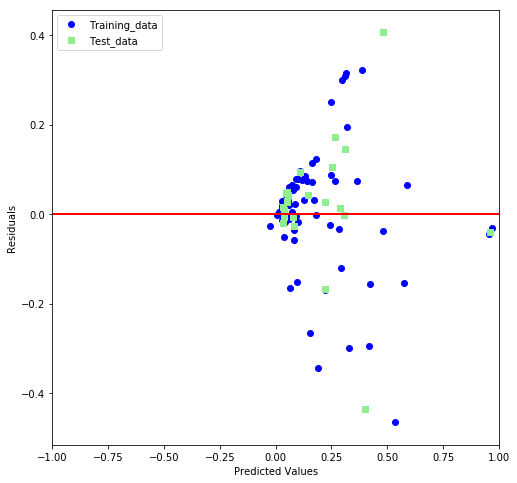

In [78]:
RegModelEval(eval_df,n=100,show=True,training=True)